# Fire Weather Prediction for Oregon and Washington: Single Location

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

%matplotlib notebook

Using TensorFlow backend.


## Importing single location NARR-gridMET data

In [196]:
# stock_name = 'GOOGL'
# df = get_stock_data(stock_name,0)
# df.tail()

df_narr_erc = pd.read_csv('/home/dp/Documents/FWP/NARR_gridMET/csv/Training/df_NARR_gridMET_Kalmiopsis_loc_all_years.csv', header='infer')
display('df_narr_erc head:', df_narr_erc.head(5))
display('df_narr_erc tail:', df_narr_erc.tail(5))

'df_narr_erc head:'

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
0,1979-01-02,0.742178,5715.97000,1.631845,-11.812575,102689.125,50.257525,84.694812,23.0
1,1979-01-03,1.580936,5650.36625,8.283511,-4.332774,101987.375,3.994009,73.726234,25.0
2,1979-01-04,-0.934074,5596.66250,10.444422,-2.467009,101681.250,-18.707662,-4.352164,15.0
3,1979-01-05,-0.733117,5600.45250,2.961868,-6.659581,101705.625,106.575925,162.815328,26.0
4,1979-01-06,1.559346,5585.27625,-0.860342,-5.186507,101381.375,40.390296,30.786914,28.0


'df_narr_erc tail:'

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
1816,1983-12-27,0.782494,5508.1800,-10.000355,-40.544150,101366.750,-53.391523,22.134313,0.0
1817,1983-12-28,-2.392586,5619.3700,-11.723684,-17.322113,102048.000,119.783963,102.634012,0.0
1818,1983-12-29,0.555242,5695.6575,0.358575,-14.475804,101878.750,-21.613663,-87.943675,0.0
1819,1983-12-30,-0.060226,5641.4650,13.035607,-20.645963,101919.875,-21.588763,-118.073588,0.0
1820,1983-12-31,-0.241805,5610.7400,2.008021,-31.701650,102444.000,-71.758150,-15.401160,0.0


<IPython.core.display.Javascript object>


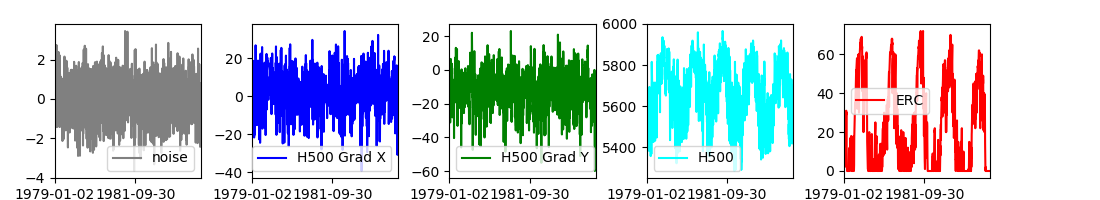

<IPython.core.display.Javascript object>


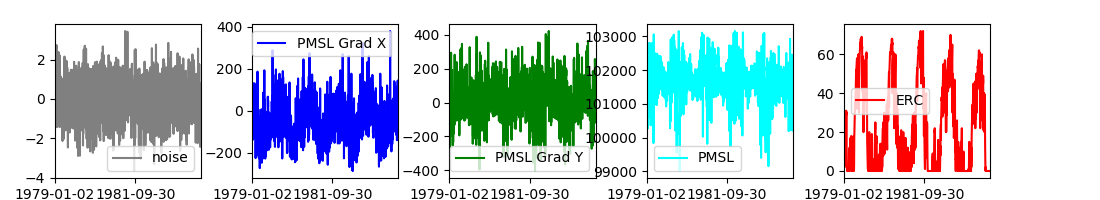

In [197]:
# Plotting ERC and H500 variables
fig1, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(11,2))
df_narr_erc.plot(x='time', y='noise', ax=ax0, color='gray')
df_narr_erc.plot(x='time', y='H500 Grad X', ax=ax1, color='blue')
df_narr_erc.plot(x='time', y='H500 Grad Y', ax=ax2, color='green')
df_narr_erc.plot(x='time', y='H500', ax=ax3, color='cyan')
df_narr_erc.plot(x='time', y='ERC', ax=ax4, color='red')
plt.subplots_adjust(wspace=0.35, left=0.05)
plt.show()

# Plotting ERC and PMSL variables
fig2, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(11,2))
df_narr_erc.plot(x='time', y='noise', ax=ax0, color='gray')
df_narr_erc.plot(x='time', y='PMSL Grad X', ax=ax1, color='blue')
df_narr_erc.plot(x='time', y='PMSL Grad Y', ax=ax2, color='green')
df_narr_erc.plot(x='time', y='PMSL', ax=ax3, color='cyan')
df_narr_erc.plot(x='time', y='ERC', ax=ax4, color='red')
plt.subplots_adjust(wspace=0.35, left=0.05)
plt.show()

In [206]:
# Specify columns to train on
cols_a = ['H500','PMSL','ERC'] # Good predictions: Test Score: 0.02 MSE (0.14 RMSE)
cols = ['H500','ERC'] # Good predictions: 0.02 MSE (0.15 RMSE)
cols_c = ['PMSL','ERC'] # Poor predictions, focused on the average ERC value of 30 - Test Score: 0.09 MSE (0.30 RMSE)
cols_d = ['H500 Grad X', 'H500 Grad Y','PMSL Grad X','PMSL Grad Y', 'ERC']
cols_e = ['H500 Grad X', 'H500 Grad Y', 'ERC']
cols_f = ['PMSL Grad X','PMSL Grad Y', 'ERC']
cols_g = ['PMSL Grad Y', 'H500 Grad Y', 'ERC']
cols_h = ['noise','ERC']
cols_i = ['ERC']
cols_j = ['noise']

df = df_narr_erc.loc[:, cols]
    
display('df to train on:', df.head(5))
n_samples = df.shape[0]
n_features = df.shape[1]-1
print('Number of samples:', n_samples)
print('Number of features:', n_features)

'df to train on:'

,H500,ERC
0,5715.97000,23.0
1,5650.36625,25.0
2,5596.66250,15.0
3,5600.45250,26.0
4,5585.27625,28.0


Number of samples: 1821
Number of features: 1


## The following is set to calculate the last feature as a result.

In [199]:
def load_data(df_fwp, seq_len):
    amount_of_features = len(df_fwp.columns)

    # We know that 'result' is the length of 'data' - 'sequence_length' (e.g. 1821 - 15 = 1806)
    # Cutting the train from test at round(0.9*1806) = 1625 + sequence_length = 1640 is all of the training data
    # This allows me to scale the training and testing data before splitting the data into batches:
    data = df_fwp.values
    print('data.shape:\n', data.shape)
    print('data[:3]:\n', data[:3])
    sequence_length = seq_len + 1

    train_test_row = round(0.9*(len(data)-sequence_length))
    print('train_test_row:\n', train_test_row)

    # Scaling:
#     scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    train_temp = data[:train_test_row,:]
    print('train_temp.shape:\n', train_temp.shape)
    print('train_temp[:10]:\n', train_temp)
    print(scaler.fit(train_temp))
    data = scaler.transform(data)
    print('Scaled data:\n', data[:10])
    print('Scaler coefs:\n', scaler.scale_)
    print('--------------------------------------------')

    # Plotting hist of scaled data:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    df.hist(cols[0], bins=20, ax=ax1)
    ax2.hist(data[:,0], bins=20)
    ax1.set_title('Unscaled')
    ax2.set_title('Scaled')
    plt.show()
    
    
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    print('result.shape:', result.shape)
    print('row:', row)
    train = result[:int(row), :]
    print('train.shape:\n', train.shape)
    print('train[:10]:\n', train[:10])
    print('********************************************')
    
    ''' With ERC: x_train, x_test include ERC '''
#     x_train = train[:, :-1] # All but the last time step in each window: train is 1625x15x2 --> x_train is 1625x14x2
#     y_train = train[:, -1][:,-1]
#     x_test = result[int(row):, :-1]
#     y_test = result[int(row):, -1][:,-1]

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    ''' Without ERC: x_train, x_test exclude ERC '''
    x_train = train[:, :-1, :-1]    # train is 1625, 15, 2 --> x_train is 1625, 14, 1
                                    # 1625 = number of time windows
                                    # 15 = number of samples in a time window (e.g. number of time steps)
                                    # 2 = number of features
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1, :-1]
    y_test = result[int(row):, -1][:,-1]
    
    print('x_train.shape before reshaping:', x_train.shape)
    print('y_train.shape before reshaping:', y_train.shape)
    print('x_train[:5] before reshaping:\n', x_train[:5])
    print('y_train[:5] before reshaping:\n', y_train[:5])
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features-1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features-1))
    print('x_train.shape after reshaping:', x_train.shape)
    print('y_train.shape after reshaping:', y_train.shape)
    print('x_train[:5] after reshaping:\n', x_train[:5])
    print('y_train[:5] after reshaping:\n', y_train[:5])

    return [x_train, y_train, x_test, y_test, data, scaler]


## Building model functions

In [200]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.05))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.05))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers): # Include ERC in training
    do_1 = 0.05
    do = 0.2
    do_3 = 0.0001

    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(do))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(do))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model3(layers): # Exclude ERC from training
    do_1 = 0.05
    do = 0.2
    do_3 = 0.0001

    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(do))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(do))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

## Setting X and Y for training and testing

,H500,ERC
0,5715.97000,23.0
1,5650.36625,25.0
2,5596.66250,15.0
3,5600.45250,26.0
4,5585.27625,28.0
...,...,...
1816,5508.18000,0.0
1817,5619.37000,0.0
1818,5695.65750,0.0
1819,5641.46500,0.0


data.shape:
 (1821, 2)
data[:3]:
 [[5715.97      23.     ]
 [5650.36625   25.     ]
 [5596.6625    15.     ]]
train_test_row:
 1625
train_temp.shape:
 (1625, 2)
train_temp[:10]:
 [[5715.97      23.     ]
 [5650.36625   25.     ]
 [5596.6625    15.     ]
 ...
 [5813.49375   26.     ]
 [5745.47125   26.     ]
 [5655.2275    26.     ]]
MinMaxScaler(copy=True, feature_range=(0, 1))
Scaled data:
 [[0.63343041 0.31944444]
 [0.53718219 0.34722222]
 [0.45839263 0.20833333]
 [0.46395299 0.36111111]
 [0.4416877  0.38888889]
 [0.44101282 0.19444444]
 [0.42792433 0.15277778]
 [0.3955176  0.125     ]
 [0.5817733  0.06944444]
 [0.50399789 0.02777778]]
Scaler coefs:
 [0.00146711 0.01388889]
--------------------------------------------


<IPython.core.display.Javascript object>


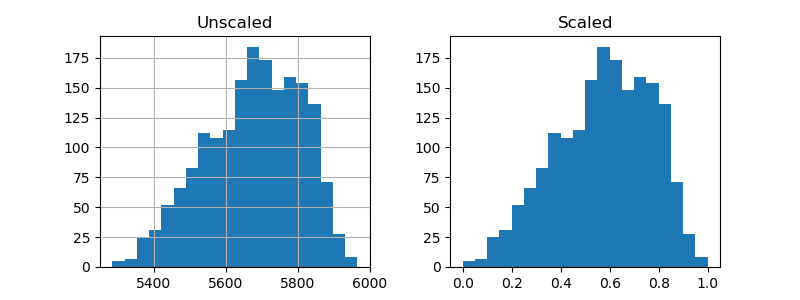

result.shape: (1806, 15, 2)
row: 1625
train.shape:
 (1625, 15, 2)
train[:10]:
 [[[0.63343041 0.31944444]
  [0.53718219 0.34722222]
  [0.45839263 0.20833333]
  [0.46395299 0.36111111]
  [0.4416877  0.38888889]
  [0.44101282 0.19444444]
  [0.42792433 0.15277778]
  [0.3955176  0.125     ]
  [0.5817733  0.06944444]
  [0.50399789 0.02777778]
  [0.32889042 0.05555556]
  [0.44624675 0.09722222]
  [0.26450426 0.06944444]
  [0.15005098 0.06944444]
  [0.33509081 0.22222222]]

 [[0.53718219 0.34722222]
  [0.45839263 0.20833333]
  [0.46395299 0.36111111]
  [0.4416877  0.38888889]
  [0.44101282 0.19444444]
  [0.42792433 0.15277778]
  [0.3955176  0.125     ]
  [0.5817733  0.06944444]
  [0.50399789 0.02777778]
  [0.32889042 0.05555556]
  [0.44624675 0.09722222]
  [0.26450426 0.06944444]
  [0.15005098 0.06944444]
  [0.33509081 0.22222222]
  [0.43085489 0.26388889]]

 [[0.45839263 0.20833333]
  [0.46395299 0.36111111]
  [0.4416877  0.38888889]
  [0.44101282 0.19444444]
  [0.42792433 0.15277778]
  [0.39

In [201]:
window = 14
display(df)
X_train, y_train, X_test, y_test, data, scaler = load_data(df, window) # Reversing the order of the samples with [::-1]

print('data.shape:', data.shape)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

print('X_train[:3,:]:\n', X_train[:3,:])
print('y_train[:3]:\n', y_train[:3])
print('X_test[:3,:]:\n', X_test[:3,:])
print('y_test[:3]:\n', y_test[:3])

## Loading the model sequence structure

In [202]:
# model = build_model([3,lag,1])
# model = build_model2([n_features+1, window, 1]) # Including ERC in x_train, x_test (e.g. [3, 14, 1])
model = build_model3([n_features, window, 1]) # Excluding ERC from x_train, x_test (e.g. [2, 14, 1])

## Executing the model & RMS/RMSE results

In [203]:
t0 = time.time()

b_s = 512
ep = 300
v_s = 0.2
erc_ex = 1 # ERC excluded? 1 if yes, 0 if no.

print('Fitting model...')
history = model.fit(
    X_train,
    y_train,
    batch_size=b_s,
    epochs=ep,
    validation_split=v_s, # Previous values: 0.1
    verbose=0)

t1 = time.time() - t0
print('Fit time {} minutes:', t1/60)

Fitting model...
Fit time {} minutes: 2.718144432703654


Maximum validation loss: 0.14362812042236328
Minimum validation loss: 0.01512269675731659


<IPython.core.display.Javascript object>


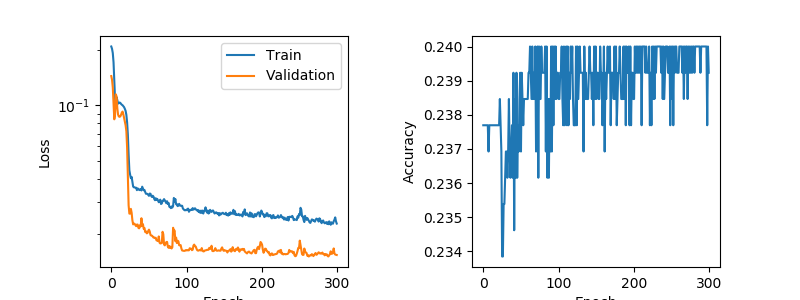

In [214]:
print('Maximum validation loss:', np.max(history.history['val_loss']))
print('Minimum validation loss:', np.min(history.history['val_loss']))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax2.plot(history.history['acc'])
ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.subplots_adjust(wspace=0.5)
fig_str = 'FWP__RNN_metrics_w='+str(window)+'_cv=1_'+'do=2_'+'epochs='+str(ep)+'_'+'bs='+str(b_s)+'_'+'erc_ex='+str(erc_ex)+'_'+'_'.join(cols)
plt.savefig(fig_str, bbox_inches='tight')
plt.show()

In [215]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# predScore = model.predict(X_train, batch_size=b_s)
# print('Prediction Score:\n', predScore)

print('Average accuracy:', np.mean(history.history['acc']))

Train Score: 0.02 MSE (0.14 RMSE)
Test Score: 0.02 MSE (0.15 RMSE)
Average accuracy: 0.23881538446515033


In [216]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

## Predictions vs Real results

In [217]:
display('prediction:\n', p)
display('X_test:\n', X_test)
display('y_test:\n', y_test)

inv_y_test = y_test/scaler.scale_[n_features] # Gets the last scaler coefficient corresponding to the ERC data
# Note that inv_p = scaler.inverse_transform(p) doesn't work because scaler has two coefficients, and p is only one column of data
inv_p = p/scaler.scale_[n_features]
print('Inverse transform of y_test:\n', inv_y_test)
print('Inverse transform of predicted:\n', inv_p)

# Concatenating X_test and p to use inverse_transform won't work either because X_test contains both
# NARR variables and ERC, and in a shape that doesn't match p.

u = 10
pr = p[u][0]
print(u, y_test[u], pr, (y_test[10]/pr)-1, abs(y_test[u]- pr))

'prediction:\n'

array([[0.2317734 ],
       [0.28938392],
       [0.34251148],
       [0.43953082],
       [0.41922462],
       [0.35295963],
       [0.2763192 ],
       [0.24227643],
       [0.31772226],
       [0.43460062],
       [0.50571775],
       [0.63060755],
       [0.6793978 ],
       [0.67503506],
       [0.6481862 ],
       [0.5305481 ],
       [0.2570488 ],
       [0.42756197],
       [0.44591036],
       [0.44953558],
       [0.47900578],
       [0.6398929 ],
       [0.65184814],
       [0.56583464],
       [0.5204582 ],
       [0.48239282],
       [0.41032884],
       [0.40820274],
       [0.5197154 ],
       [0.70338285],
       [0.77756584],
       [0.80581355],
       [0.8111161 ],
       [0.796075  ],
       [0.77431417],
       [0.76384914],
       [0.78093934],
       [0.8066439 ],
       [0.81720954],
       [0.8162831 ],
       [0.8158761 ],
       [0.8370693 ],
       [0.82050973],
       [0.78977215],
       [0.7824992 ],
       [0.7890059 ],
       [0.81093   ],
       [0.816

'X_test:\n'

array([[[0.59508553],
        [0.59282984],
        [0.57060489],
        ...,
        [0.60179758],
        [0.58330644],
        [0.55347816]],

       [[0.59282984],
        [0.57060489],
        [0.68035057],
        ...,
        [0.58330644],
        [0.55347816],
        [0.72760083]],

       [[0.57060489],
        [0.68035057],
        [0.61706658],
        ...,
        [0.55347816],
        [0.72760083],
        [0.82158602]],

       ...,

       [[0.65384164],
        [0.60114472],
        [0.56317396],
        ...,
        [0.37366493],
        [0.36386643],
        [0.32857866]],

       [[0.60114472],
        [0.56317396],
        [0.50042546],
        ...,
        [0.36386643],
        [0.32857866],
        [0.49170713]],

       [[0.56317396],
        [0.50042546],
        [0.61436892],
        ...,
        [0.32857866],
        [0.49170713],
        [0.60362964]]])

'y_test:\n'

array([0.52777778, 0.55555556, 0.56944444, 0.375     , 0.375     ,
       0.38888889, 0.58333333, 0.43055556, 0.61111111, 0.625     ,
       0.45833333, 0.65277778, 0.69444444, 0.68055556, 0.68055556,
       0.69444444, 0.41666667, 0.56944444, 0.63888889, 0.66666667,
       0.68055556, 0.65277778, 0.65277778, 0.69444444, 0.69444444,
       0.69444444, 0.72222222, 0.73611111, 0.75      , 0.73611111,
       0.73611111, 0.73611111, 0.75      , 0.76388889, 0.77777778,
       0.76388889, 0.77777778, 0.79166667, 0.76388889, 0.79166667,
       0.81944444, 0.84722222, 0.86111111, 0.86111111, 0.86111111,
       0.86111111, 0.86111111, 0.83333333, 0.81944444, 0.84722222,
       0.63888889, 0.61111111, 0.58333333, 0.77777778, 0.76388889,
       0.75      , 0.47222222, 0.375     , 0.31944444, 0.30555556,
       0.30555556, 0.47222222, 0.51388889, 0.54166667, 0.58333333,
       0.625     , 0.63888889, 0.61111111, 0.625     , 0.63888889,
       0.625     , 0.66666667, 0.69444444, 0.69444444, 0.69444

Inverse transform of y_test:
 [38. 40. 41. 27. 27. 28. 42. 31. 44. 45. 33. 47. 50. 49. 49. 50. 30. 41.
 46. 48. 49. 47. 47. 50. 50. 50. 52. 53. 54. 53. 53. 53. 54. 55. 56. 55.
 56. 57. 55. 57. 59. 61. 62. 62. 62. 62. 62. 60. 59. 61. 46. 44. 42. 56.
 55. 54. 34. 27. 23. 22. 22. 34. 37. 39. 42. 45. 46. 44. 45. 46. 45. 48.
 50. 50. 50. 51. 52. 51. 54. 57. 60. 35. 26. 37. 41. 30. 42. 44. 47. 48.
 49. 35. 45. 46. 47. 45. 49. 36. 26. 21. 24. 34. 34. 25. 37. 39. 38. 39.
 39. 40. 28. 21. 20. 34. 37. 39. 38. 39. 26. 20. 14. 10.  7.  3.  1.  0.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
Inverse transform of predicted:
 [[16.687685 ]
 [20.835642 ]
 [24.660826 ]
 [31.64622  ]
 [30.184172 ]
 [25.413094 ]
 [19.894983 ]
 [17.443903 ]
 [22.876003 ]
 [31.291245 ]
 [36.41168  ]
 [45.403744 ]
 [48.91664  ]
 [48.602524 ]
 [46.

In [218]:
print(X_test.shape)
print(y_test.shape)
print(p.shape)
print(X_test)

(181, 14, 1)
(181,)
(181, 1)
[[[0.59508553]
  [0.59282984]
  [0.57060489]
  ...
  [0.60179758]
  [0.58330644]
  [0.55347816]]

 [[0.59282984]
  [0.57060489]
  [0.68035057]
  ...
  [0.58330644]
  [0.55347816]
  [0.72760083]]

 [[0.57060489]
  [0.68035057]
  [0.61706658]
  ...
  [0.55347816]
  [0.72760083]
  [0.82158602]]

 ...

 [[0.65384164]
  [0.60114472]
  [0.56317396]
  ...
  [0.37366493]
  [0.36386643]
  [0.32857866]]

 [[0.60114472]
  [0.56317396]
  [0.50042546]
  ...
  [0.36386643]
  [0.32857866]
  [0.49170713]]

 [[0.56317396]
  [0.50042546]
  [0.61436892]
  ...
  [0.32857866]
  [0.49170713]
  [0.60362964]]]


<IPython.core.display.Javascript object>


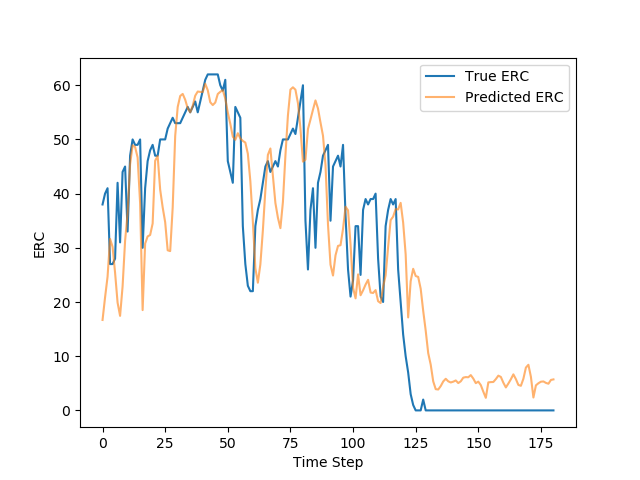

In [219]:
plt.figure()
plt.plot(inv_y_test, label='True ERC')
plt.plot(inv_p, label='Predicted ERC', alpha=0.6)
plt.legend(loc='upper right')
plt.xlabel('Time Step')
plt.ylabel('ERC')
fig_str = 'FWP__RNN_results_w='+str(window)+'_cv=1_'+'do=2_'+'epochs='+str(ep)+'_'+'bs='+str(b_s)+'_'+'erc_ex='+str(erc_ex)+'_'+'_'.join(cols)
plt.savefig(fig_str, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


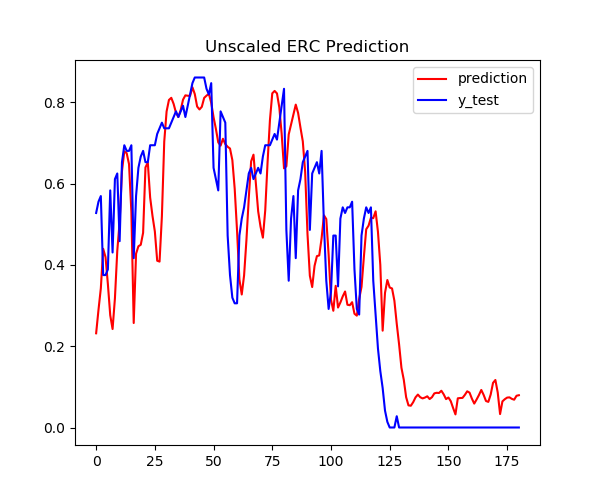

In [220]:
import matplotlib.pyplot as plt2

plt2.figure(figsize=(6,5))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper right')
plt2.title('Unscaled ERC Prediction')
plt2.show()

<IPython.core.display.Javascript object>


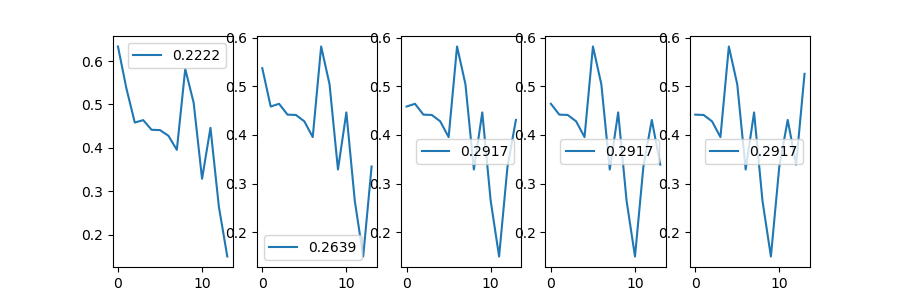

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
0,1979-01-02,0.742178,5715.97000,1.631845,-11.812575,102689.125,50.257525,84.694812,23.0
1,1979-01-03,1.580936,5650.36625,8.283511,-4.332774,101987.375,3.994009,73.726234,25.0
2,1979-01-04,-0.934074,5596.66250,10.444422,-2.467009,101681.250,-18.707662,-4.352164,15.0
3,1979-01-05,-0.733117,5600.45250,2.961868,-6.659581,101705.625,106.575925,162.815328,26.0
4,1979-01-06,1.559346,5585.27625,-0.860342,-5.186507,101381.375,40.390296,30.786914,28.0


0    23.0
1    25.0
2    15.0
3    26.0
4    28.0
Name: ERC, dtype: float64


In [221]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(9,3))
ax1.plot(X_train[0, :], label=round(y_train[0], 4))
ax2.plot(X_train[1, :], label=round(y_train[1], 4))
ax3.plot(X_train[2, :], label=round(y_train[2], 4))
ax4.plot(X_train[3, :], label=round(y_train[3], 4))
ax5.plot(X_train[4, :], label=round(y_train[3], 4))
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
plt.show()
display(df_narr_erc.head())
print(df_narr_erc.iloc[0:5, -1])

<IPython.core.display.Javascript object>


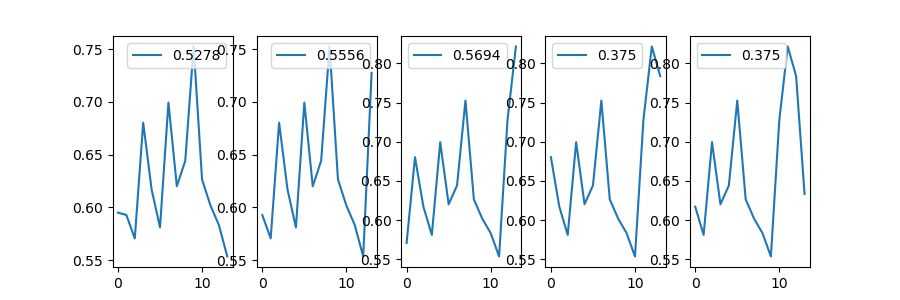

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
0,1979-01-02,0.742178,5715.97000,1.631845,-11.812575,102689.125,50.257525,84.694812,23.0
1,1979-01-03,1.580936,5650.36625,8.283511,-4.332774,101987.375,3.994009,73.726234,25.0
2,1979-01-04,-0.934074,5596.66250,10.444422,-2.467009,101681.250,-18.707662,-4.352164,15.0
3,1979-01-05,-0.733117,5600.45250,2.961868,-6.659581,101705.625,106.575925,162.815328,26.0
4,1979-01-06,1.559346,5585.27625,-0.860342,-5.186507,101381.375,40.390296,30.786914,28.0


1640    40.0
1641    41.0
1642    27.0
1643    27.0
1644    28.0
Name: ERC, dtype: float64


In [222]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(9,3))
ax1.plot(X_test[0, :], label=round(y_test[0], 4))
ax2.plot(X_test[1, :], label=round(y_test[1], 4))
ax3.plot(X_test[2, :], label=round(y_test[2], 4))
ax4.plot(X_test[3, :], label=round(y_test[3], 4))
ax5.plot(X_test[4, :], label=round(y_test[3], 4))
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
plt.show()
display(df_narr_erc.head())
print(df_narr_erc.iloc[-181:-176, -1])